# AMLD-2021-Sketchy: Performance Solution

In the previous notebook, we visualised the datasets, coded the model encoder and the losses. In this notebook, we compute the perfomance of the model and then visualise the inference.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import torch
import torch.nn as nn
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

from src.data.utils import default_image_loader, get_class_dict
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint, normalise_attention

## Metrics computation

In this part, we describe how to compute the performance metrics. We present an overall explanation and then multiple exercise will guide to computation.

The metrics that we aim to compute are `map_`, `map_100`, and `prec_100`. These metrics are all computed based on the embeddings. 

For each sketch embedding, we order the images embeddings based on their 'similarity'. The closer the image is to the sketch, the more 'similar' it is. 

Therefore, we create a `similarity` matrix and a `class_matches` matrix. The matrices have a row for each sketch and a column for each image. 

In the `similarity` matrix, each cell correspond to the distance between the sketch and the image. In the `class_matches` matrix, each cell is one if the class of the sketch and the image are the same and 0 otherwise.

We then order the columns of `similarity` and `class_matches` based on the similarity values: the columns are reordered such that the most similar columns are first and the least similar are last. The sorted matrices are `sorted_similarity` and `sorted_class_match` respectively.

Once we have the `sorted_similarity` and `sorted_class_matches` matrices, we can compute the metrics easily. 

- `map_` is the [mean average precision](https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2) of all the items. It summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight: $AP=\sum_n(R_n - R_{n-1})P_n$ where $P_n$ and $R_n$ are the precision and recall at the nth threshold. (See [sklearn.metrics.average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html).)

- `map_100` is the mean average precision of the 100 most similar items to each sketch (100 first columns).

- `prec_100` is the precision of the 100 first most similar items to each sketch (100 first columns). For one sketch, it is the sum of classes that matched (with a 1) divided by the number of images (100). For all sketches, it is the mean of the result for each sketch.

### Load images and sketch embeddings

As explained, to compute the metrics, we need the embeddings of each images and sketches of the **test set**. Therefore, we need to iterate through all images and sketches and pass them through the image or sketch encoder respectively to get the embedding.

As this is a long and quite straightforward process, we already have done it for you and saved them with their labels. Here is the function to load them:

In [2]:
def load_precomputed_embeddings(embeddings_path, image_type):
    
    emb_path = os.path.join(embeddings_path, f"quickdraw_{image_type}_array.npy")
    metadata_path = os.path.join(embeddings_path, f"quickdraw_{image_type}_meta.csv")

    with open(emb_path, "rb") as f:
        images_embeddings = np.load(f)
        
    df = pd.read_csv(metadata_path, sep=" ")
    images_fnames, images_classes = df["fnames"].to_list(), df["classes"].to_list()
    
    return images_embeddings, images_classes, images_fnames

In [3]:
MODEL_PATH = "/io/models/quickdraw_training/precomputed_embeddings"
images_embeddings, images_classes, images_fnames = load_precomputed_embeddings(MODEL_PATH, 'images')
sketch_embeddings, sketch_classes, sketch_fnames = load_precomputed_embeddings(MODEL_PATH, 'sketches')

In [4]:
images_embeddings.shape, sketch_embeddings.shape

((5131, 256), (8415, 256))

### Sort by Similarity

Now that we have both the embeddings for the images and the sketches, we compute the similarity between them in the embeddings space. We define the similarity by the following simple function (with the distance being the Euclidian distance between both embeddings): $$similarity = \frac{1}{1 + distance}$$ Embeddings close to each others are more similar than embeddings far from each others.

In [5]:
from scipy.spatial.distance import cdist

In [6]:
def get_similarity(image_embeddings, sketch_embeddings):
    '''
    Computes images and sketch similarity in the feature space.
    The distance is computed as the euclidean distance. 
    Here, we want similarity = 1/(1 + distance)
    Args:
        - im_embeddings: embeddings of the images [MxE]
        - sketch_embeddings: embeddings of the sketches [NxE]
    Return:
        - similarity: similarity value between images and sketches embeddings [NxM]
    '''
    similarity = 1/(1 + cdist(sketch_embeddings, image_embeddings, 'euclidean'))
    return similarity

In [7]:
similarity = get_similarity(images_embeddings, sketch_embeddings)
similarity.shape

(8415, 5131)

We compute the `class_matches` matrix (the rows are sketches and the columns are images) with 1 where the label and sketch match and 0 otherwise.

In [8]:
def compare_classes(class_image, class_sketch):
    '''
    Compare classes of images and sketches
    Args:
        - class_im: list of classes of the images [M]
        - class_sk: list of classes of the sketches [N]
    Return:
        - array [NxM] of 1 where the image and sketch belong to the same class and 0 elsewhere
    '''
    class_sketch = np.expand_dims(class_sketch, axis=1)
    class_image = np.expand_dims(class_image, axis=0)
    class_matches = (class_sketch == class_image) * 1
    return class_matches

In [9]:
class_matches = compare_classes(images_classes, sketch_classes)
class_matches.shape

(8415, 5131)

We now sort the matrices by similarity meaning that for each sketch, we reorder the columns based on their similarity values. An image similar to a sketch should be in the beginning of the list (first columns) and a very different image should be at the end of the list (last columns).

In [10]:
def sort_class_by_similarity(similarity, class_matches):
    '''
    Sort the matrices by similarity. Column order based on similarity.
    The distance is computed as the euclidean distance. 
    Args:
        - similarity: array [NxM] similarity between sketches and images
        - class_matches: array [NxM], 1 where the image and sketch belong to the same class, 0 elsewhere
    Return:
        - sorted_similarity: array [NxM] sorted similarity between sketches and images
        - sorted_class_matches: array [NxM], sorted class_matches
    '''
    similarity.squeeze()
    sorted_similarity_indexes = (-similarity).argsort()
    sorted_similarity = []  # list of similarity values ordered by similarity (most to least similar)
    sorted_class = []       # list of class match ordered by similarity (0 if different, 1 if same)
    for index in range(0, sorted_similarity_indexes.shape[0]):
        sorted_similarity.append(similarity[index, sorted_similarity_indexes[index, :]])
        sorted_class.append(class_matches[index, sorted_similarity_indexes[index, :]])

    sorted_similarity = np.array(sorted_similarity)
    sorted_class_matches = np.array(sorted_class)
    return sorted_similarity, sorted_class_matches

In [11]:
sorted_similarity, sorted_class_matches = sort_class_by_similarity(similarity, class_matches)
sorted_similarity.shape, sorted_class_matches.shape

((8415, 5131), (8415, 5131))

### Metrics

**TODO** Compute the mAP (mean average precision), mAP@100 and Precision@100 of the results.

In [12]:
# Solution
map_ = average_precision_score(sorted_class_matches, sorted_similarity)
print(f'The mean average precision of all samples is {np.round(map_, 4)}.')

limit = 100
map_100 = average_precision_score(sorted_class_matches[:, 0:limit], sorted_similarity[:, 0:limit])
print(f'The mean average precision of the 100 most similar is {np.round(map_100, 4)}.')

prec_100 = np.mean(sorted_class_matches[:, 0:limit])
prec_100 = np.mean(np.sum(sorted_class_matches[:, :limit], axis=1)/limit)
print(f'The precision of the 100 most similar is {np.round(prec_100, 4)}.')

The mean average precision of all samples is 0.0164.
The mean average precision of the 100 most similar is 0.1896.
The precision of the 100 most similar is 0.1447.


## Inference pipeline

We will now perform an inference on a sketch, retrieve the NUM_CLOSEST closest images and plot them together.

The last part exercise of this notebook is to take part in coding the pipeline to plot images like the ones below:
<img src="images/ant_and_attention.png">
<img src="images/ant_best_guess.png">

We break the problem into multiple steps in different cells.

In [13]:
NUM_CLOSEST = 4 # number of closest images to show.

### Data

The images embeddings were already loaded in the `Metric Computation` part and are ready to use.

We need a sketch to perform the inference on. Therefore, we prepared the image of the camel below. We load it, prepare it to go through the sketch encoder network and plot it.  

In [14]:
# Load the camel sketch
sketch_fname = 'images/camel_sketch.png'
sketch = default_image_loader(sketch_fname) # basically load and resize the image

transform = transforms.Compose([transforms.ToTensor()])
sketch = transform(sketch) # apply transform
sketch = sketch.unsqueeze(0) # expand because no batch

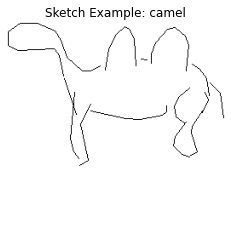

In [15]:
# Small sketch plot
plt.imshow(plt.imread(sketch_fname), cmap="gray");
plt.title('Sketch Example: camel')
plt.axis('off');

### Model
We need a model to transform the sketch to its embedding. Therefore, we load the encoder network with the sketch checkpoint data.

In [16]:
# We create the model
EMBEDDING_SIZE = 256
CHECKPOINT_PATH = "/io/models/sktu_copy/checkpoint.pth"

**TODO**: Are you able to load the model of sketch encoder ? We did it in the previous notebook.

In [17]:
# Get the encoder, load the checkpoint and then load the checkpoint in the sketch encoder
sketch_encoder = EncoderCNN(EMBEDDING_SIZE)
checkpoint = load_checkpoint(CHECKPOINT_PATH)
sketch_encoder.load_state_dict(checkpoint["sk_state"])

=> loading model '/io/models/sktu_copy/checkpoint.pth'
=> loaded model '/io/models/sktu_copy/checkpoint.pth' (epoch 49, map 0.3094873427878774)


<All keys matched successfully>

In [18]:
sketch_encoder.eval()
torch.set_grad_enabled(False);

### Inference
We now have everything to do the inference! Let's get on :)

**TODO**: Compute the embeddings and the attention map of the sketch

In [19]:
# 1. Solution
sketch_embedding, sketch_attention = sketch_encoder(sketch)

For the plot, we resize the attention such that it is the same size as the initial sketch and normalise it between 0 and 1. 

In [20]:
# 2. Get the attention values normalized and at the same size as the sketch
sketch_attention = normalise_attention(sketch_attention, sketch)

**TODO**: Compute now the similarity between images and sketch and sort the similarity

In [21]:
# 3. Solution
similarity = get_similarity(sketch_embedding, images_embeddings)
similarity = similarity.squeeze()
sorted_similarity_indexes = (-similarity).argsort()

**TODO**: Keep the labels of the NUM_CLOSEST most similar images.

In [22]:
# 4. Solution
sorted_fnames = [images_fnames[i] for i in sorted_similarity_indexes[0: NUM_CLOSEST + 1]]
sorted_labels = [images_classes[i] for i in sorted_similarity_indexes[0: NUM_CLOSEST + 1]]

We now load the image and retrieve the class names based on the class labels.

In [23]:
# 5. Load images and get labels
DATA_PATH =  "/io/data/raw/Quickdraw"
dict_class_to_id = get_class_dict(DATA_PATH)
dict_id_to_class = {v:k for k,v in dict_class_to_id.items()}
closest_labels = [dict_id_to_class[label] for label in sorted_labels]

closest_images = [default_image_loader('../../' + fname) for fname in sorted_fnames]

### Visualisation

Finally, we are ready to plot the images. 

In the first image, we plot the original sketch on the left and then the superposed sketch with the attention heatmap on the right. 

**TODO**: In the second image, plot the NUM_CLOSEST closest images with their labels in the title.

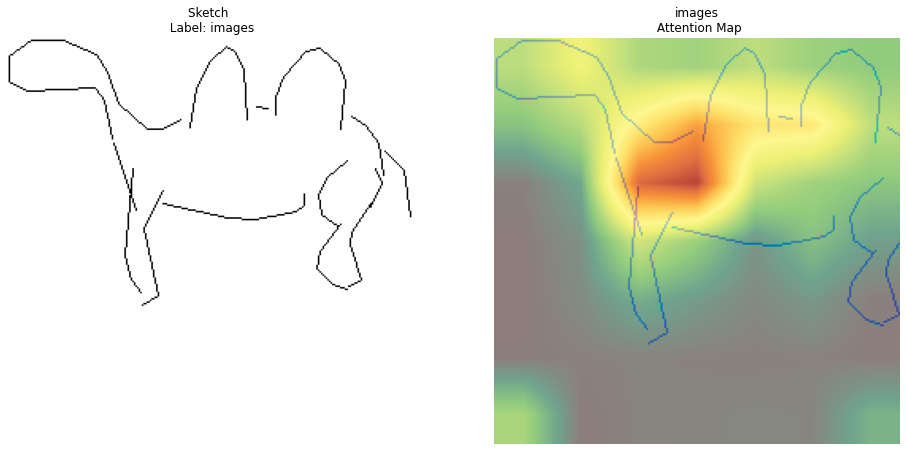

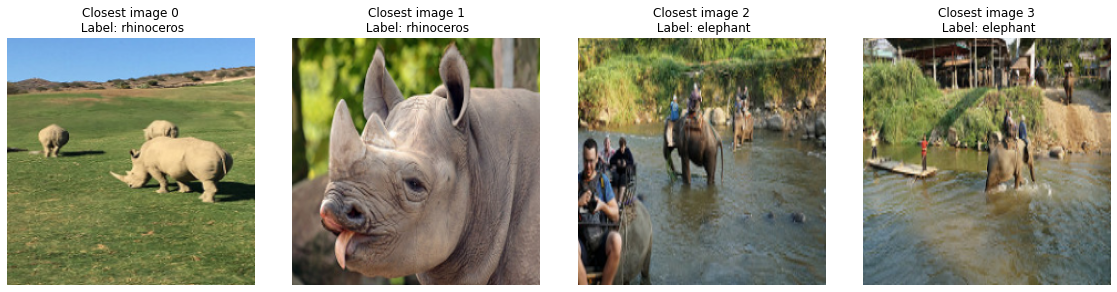

In [24]:
# 6. Solution
fig1, ax1 = plt.subplots(1, 2, figsize=(NUM_CLOSEST*4,NUM_CLOSEST*2))

## Figure 1 ##
# Plot sketch and attention map
sk = plt.imread(sketch_fname)
ax1[0].imshow(sk, cmap="gray")
ax1[0].set(title="Sketch \n Label: " + sketch_fname.split("/")[-2])
ax1[0].axis("off")

# We remove unecessary dimension from the heat map for the plot
heat_map = sketch_attention.squeeze()
ax1[1].imshow(sk)
ax1[1].imshow(255 * heat_map, alpha=0.7, cmap="Spectral_r")
ax1[1].set(title=sketch_fname.split("/")[-2] + "\n Attention Map")
ax1[1].axis("off")

## Figure 2 ##
fig2, ax2 = plt.subplots(1, NUM_CLOSEST, figsize=(NUM_CLOSEST*4,4))
for i in range(NUM_CLOSEST):
    ax2[i].imshow(closest_images[i])
    ax2[i].set(title='Closest image ' + str(i) + '\n Label: ' + closest_labels[i])
    ax2[i].axis('off')

plt.tight_layout()
plt.show()

All done, congratulations!